# Evaluating Classifiers: The Confusion Matrix and AUC-ROC
---

### Learning Objectives

- Understand true positives, false positives, true negatives, and false negatives.
- Define a confusion matrix and how to apply it.
- Calculate the most common classification evaluation metrics.
- Understand what the F1 score represents and how to calculate it.
- Learn when it's advantageous to change the threshold for prediction for a classification model.
- Manually change the threshold for prediction on the cancer data set and observe the results.
- Understand receiver operating characteristic (ROC) curves and why they're useful.
- Learn to plot an ROC curve.

### Lesson Guide
- [Introduction: Evaluating Classifiers](#intro)
- [The Baseline Accuracy](#baseline)
- [Build a KNN Model to Predict Spam](#knn)
- [Predicting Labels vs. Predicting Probabilities](#labels-vs-probs)
- [The Confusion Matrix](#confusion-matrix)
- [Fundamental Classifier Metrics](#metrics)
    - [Accuracy](#accuracy)
    - [Sensitivity/Recall/True Positive Rate (TPR)](#sensitivity)
    - [False Positive Rate (FPR)](#fpr)
    - [Specificity/True Negative Rate (TNR)](#specificity)
    - [Precision/Positive Predictive Value](#precision)
- [The F1 Score and Scikit-Learn's `Classification_Report`](#f1-score)
- [Changing the Threshold for Prediction](#threshold)
    - [Load the UCI Breast Cancer Data](#uci)
    - [Evaluate Prediction on a Test Set](#testing)
- [The ROC Curve](#roc-curve)
- [Reference Table of Common Classification Metric Terms and Definitions](#table)
- [Additional Resources](#resources)


In [0]:
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

<a id='intro'></a>

## Introduction: Evaluating Classifiers

---
In this lesson, we'll cover the fundamentals of evaluating classifiers. It is important to note that the evaluation of classifier models is more complex than that of regression models.

To ground the theory in a real-world example, we will use a spam data set on which to build and evaluate classifiers. The spam data set is 1,001 columns wide, containing an `is_spam` binary marker signifying whether or not a given email is spam. That data set also contains an additional 1,000 columns, each corresponding to a word that could have appeared in the email (also marked with 0 or 1).

**Load the spam data below and print out the header.**

In [0]:
#1 Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 17.9MB/s 


In [0]:
#2. Get the file
#make sure you upload all your data files to your Google drive and change share->Advanced->change->anyone with the link can view
downloaded = drive.CreateFile({'id':'1OOnEGL5JzeNRTj9w9aERzWQjYzLzK04g'}) # replace the id with id of file you want to access
downloaded.GetContentFile('spam_words_wide.csv')

In [0]:
spam = pd.read_csv('spam_words_wide.csv')

In [0]:
spam.shape

(5572, 1001)

In [0]:
spam.sample(10)

,is_spam,getzed,86021,babies,sunoco,ultimately,thk,voted,spatula,fiend,...,itna,borin,thoughts,iccha,videochat,freefone,pist,reformat,strict,69698
1017,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
561,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1091,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5368,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2246,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5165,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
718,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4966,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2597,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
print(spam.shape, spam.is_spam.mean())

(5572, 1001) 0.13406317300789664


### Consider these scenarios:

** Case 1:  You have %95 non-spam. **
Model accuracy is %94


** Case 2:  You have %50 spam. **
Model accuracy is %70


**Which one is the best? Follow up: Why?**


> /poll "Between cases 1 and 2, which is the better model based on accuracy?  Why?


<a id='baseline'></a>

## The Baseline Accuracy

---

The importance of calculating your baseline accuracy when building and evaluating classifiers cannot be overstated.

> **Baseline Accuracy**: The accuracy that can be achieved by a model by simply guessing the majority class for every observation.

As human beings, we are inclined to think that "50-percent accuracy" is equivalent to predicting by chance. A 50-percent accuracy, however, only equates to predicting by chance in a very specific context; that is, when we have equal proportions of positive and negative (1 and 0) target class labels in our data set, or in the case of multi-class problems, when the majority class makes up 50 percent of the labels.

> **`baseline_accuracy = majority_class_N / total_N`**

In a binary class problem, however, the reality is that your data set is more likely to be unbalanced, and the more unbalanced it is, the higher the baseline accuracy becomes. This is important to remember because if 99 percent of your observations are of one class, predicting 99 percent of them correctly with a model is performing at chance.


#### Calculate the baseline accuracy for the spam data set.

In [0]:
baseline_acc = max(spam.is_spam.mean(),1. - spam.is_spam.mean())
baseline_acc

0.8659368269921034

<a id='knn'></a>

## Set up a KNN Model to Predict Spam

---

We will use the first column as target and the rest of the column in the dataframe as features.

In [0]:
from sklearn.neighbors import KNeighborsClassifier
y = spam.is_spam
X = spam.drop(['is_spam'], axis=1)

knn = KNeighborsClassifier()

#### Cross-validate the accuracy of the model.

Use 5 folds. How does the mean performance across folds compare to the baseline accuracy?

In [0]:
%%time
from sklearn.model_selection import cross_val_score

accs = cross_val_score(knn, X, y, cv=5)
print(accs)
print(np.mean(accs))

[0.9264574  0.92466368 0.92549372 0.92908438 0.94165171]
0.9294701757493298
CPU times: user 55.2 s, sys: 64.6 ms, total: 55.3 s
Wall time: 55.3 s


<a id='labels-vs-probs'></a>

## Predicting Labels vs. Predicting Probabilities

---

Scikit-learn classification models come with two distinct prediction functions:

1) `.predict()`: Predicts the labels (classes) of observations. 
2) `.predict_proba()`: Predicts the *probability of membership to each class*.

The `.predict()` function will return the predicted labels for a design matrix as a vector of integer labels. 

In contrast, the `.predict_proba()` function will return the probabilities as a matrix, where the columns are organized in increasing order of the class labels (e.g., the first column is probabilities for class 0, the second column is probabilities for class 1).

**Fit the KNN model and print out the predicted labels and probabilities for a few points.**

In [0]:
%%time
knn.fit(X, y)

CPU times: user 441 ms, sys: 2.98 ms, total: 444 ms
Wall time: 444 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [0]:
%%time
print('knn prediction score:',knn.score(X,y))

knn prediction score: 0.9409547738693468
CPU times: user 1min 2s, sys: 23.8 ms, total: 1min 2s
Wall time: 1min 2s


In [0]:
#Let's see how the model predict the first 10 rows
knn.predict(X.iloc[0:10, :])

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

In [0]:
print(y[0:10])

0    0
1    0
2    1
3    0
4    0
5    1
6    0
7    0
8    1
9    1
Name: is_spam, dtype: int64


In [0]:
knn.predict_proba(X.iloc[0:10, :])

array([[1. , 0. ],
       [0.8, 0.2],
       [0.8, 0.2],
       [1. , 0. ],
       [0.8, 0.2],
       [0.6, 0.4],
       [0.8, 0.2],
       [1. , 0. ],
       [0.2, 0.8],
       [0. , 1. ]])

<a id='confusion-matrix'></a>

## The Confusion Matrix

---

The confusion matrix is a table representing the performance of your model to classify labels correctly.

**A confusion matrix for a binary classification task:**

|   |Predicted Positive | Predicted Negative |   
|---|---|---|
|**Actual Positive** | True positive (TP)  | False negative (FN)  |  
|**Actual Negative**  | False positive (FP)  | True negative (TN)  | 

In a binary classifier, the "true" class is typically labeled with 1 and the "false" class is labeled with 0. 

> **True Positive**: A positive class observation (1) is correctly classified as positive by the model.

> **False Positive**: A negative class observation (0) is incorrectly classified as positive by the model.

> **True Negative**: A negative class observation is correctly classified as negative.

> **False Negative**: A positive class observation is incorrectly classified as negative.

Columns of the confusion matrix sum to the predictions by class. Rows of the matrix sum to the actual values within each class. You may encounter confusion matrices where the actual is contained in the columns and the predicted is contained in the rows; the meaning is the same, but the table will be reoriented.

> **Note:** Remembering what the cells in the confusion matrix represent can be a little tricky. The first word (true or false) indicates whether or not the model was correct. The second word (positive or negative) indicates the *model's guess* (not the actual label).

#### Calculate the confusion matrix metrics for your model below.

In [0]:
predicted = knn.predict(X)

In [0]:
tp = np.sum((y == 1) & (predicted == 1))
fp = np.sum((y == 0) & (predicted == 1))
tn = np.sum((y == 0) & (predicted == 0))
fn = np.sum((y == 1) & (predicted == 0))
print(tp, fp, tn, fn)

433 15 4810 314


#### Verify that this is the same as the numbers you get from scikit-learn's `metrics.confusion_matrix`.

In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
labels = y.unique()
cm = confusion_matrix(y, predicted,labels)

tn, fp, fn, tp = cm.ravel()
print("true negative",tn)
print("false positive",fp)
print("false negative",fn)
print("true positive",tp)

true negative 4810
false positive 15
false negative 314
true positive 433


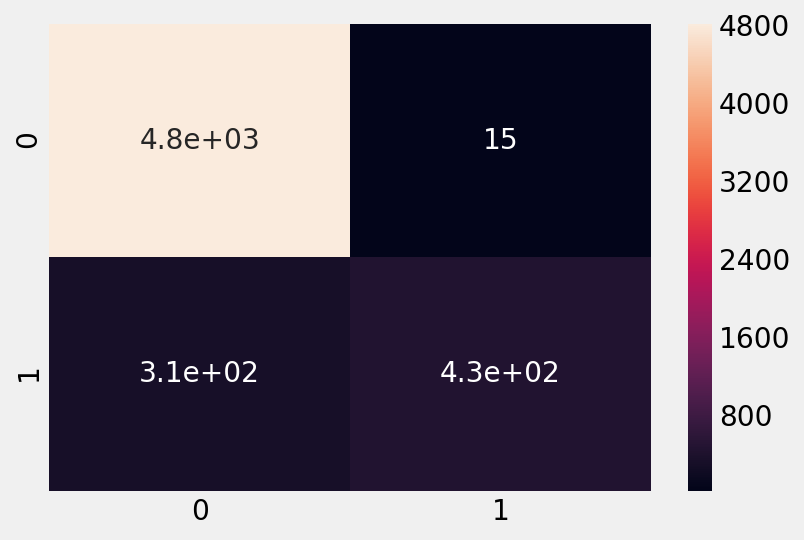

In [0]:
import seaborn as sn
df_cm = pd.DataFrame(cm, index = [i for i in labels],
                  columns = [i for i in labels])

sn.heatmap(df_cm, annot=True)

<a id='metrics'></a>

## The Fundamental Classifier Metrics

---

All metrics we use to evaluate classifiers are tied to the content of the confusion matrix. Remember that, for the binary classification case, we have four cells in the confusion matrix:

- **`tp`**: true positives (classifier correct; classifier guessed 1).
- **`fp`**: false positives (classifier incorrect; classifier guessed 1).
- **`tn`**: true negative (classifier correct; classifier guessed 0).
- **`fn`**: false negative (classifier incorrect; classifier guessed 0).

Below are the fundamental metrics that data scientists use to evaluate the performance of their classifier models.

---

<a id='accuracy'></a>
### $\color{red}{\text{Accuracy}}$

With the total population as:

> **`total_population = tp + fp + tn + fn`**

The $\color{red}{\text{accuracy}}$ can be calculated as:
> <span style="color:red">**`accuracy = (tp + tn) / total_population`**</span>

This is just the proportion of correct guesses made by the model, regardless of class. The `.score()` function attached to scikit-learn classification model objects defaults to returning the accuracy of the model's predictions given an `X` and `y`.

The inverse of the accuracy is known as the **misclassification rate**, which is calculated as:

> **`misclassification_rate = (fp + fn) / total_population`**

**Calculate the $\color{red}{\text{accuracy}}$ using the confusion matrix cells.**
- Validate that it is the same as `metrics.accuracy_score`.

In [0]:
from sklearn.metrics import accuracy_score

total_population = tp + fp + tn + fn

print ('accuracy with library call: %.2f%%' % (accuracy_score(y, predicted)*100))
print ('accuracy with manual calculation: %.2f%%' % (float(tp + tn) / total_population*100))

accuracy with library call: 94.10%
accuracy with manual calculation: 94.10%


---
<a id='sensitivity'></a>
### Sensitivity/$\color{red}{\text{Recall}}$/True Positive Rate

The true positive rate is the percent of times that the model correctly predicted 1 when the label was in fact 1. This is alternatively known as the **sensitivity** or $\color{red}{\text{recall}}$. 

This is calculated as:

> **`recall = tp / (tp + fn)`**

**Calculate the recall with the confusion matrix cells.**
- Validate that this is the same as `metrics.recall_score`.

In [0]:
from sklearn.metrics import recall_score

print (recall_score(y, predicted))
print (float(tp) / (tp + fn))

0.5796519410977242
0.5796519410977242


---
<a id='fpr'></a>
### False Positive Rate

Alternatively, the false positive rate measures the percent of times the model predicts a 1 when the target class is actually a 0. 

> **`fpr = fp / (tn + fp)`**

**Calculate the FPR using the confusion matrix cells.**

In [0]:
print (float(fp) / (tn + fp))

0.0031088082901554403


---
<a id='specificity'></a>
### Specificity/True Negative Rate

The true negative rate measures the percent of times the classifier predicted the class was 0 out the number of actual times the class was 0. It is the sister metric to sensitivity, which measures the same thing but for positives.

> **`specificity = tn / (tn + fp)`**

**Calculate specificity using the confusion matrix cells.**

In [0]:
specificity = float(tn) / (tn + fp)
print (specificity)

0.9968911917098445


---
<a id='precision'></a>
### $\color{red}{\text{Precision}}$/Positive Predictive Value

Precision measures the percent of times the classifier was correct when it was predicting the true (1) class.

> **`precision = tp / (tp + fp)`**

The idea of the classifier being _precise_ is subtly different than it being _accurate_. Precision is a measure of correctness only for its positive class predictions, whereas accuracy is a measure of correctness for all predictions.

**Calculate precision using the confusion matrix cells.**
- Validate that this is the same as `metrics.precision_score`.

In [0]:
from sklearn.metrics import precision_score

print (precision_score(y, predicted))
print (float(tp) / (tp + fp))

0.9665178571428571
0.9665178571428571


<a id='f1-score'></a>

## F1 Score and the `Classification_Report`

---

Scikit-learn's `metrics.classification_report` helps diagnose the effectiveness of your classifier. The report focuses on the precision, recall, and a metric known as the F1 score.

The F1 score is the [harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean) of the precision and recall metrics. Blending the two is useful; precision measures how effectively the classifier performs when it is predicting a 1, whereas recall measures how many of the total 1 classes out of all the 1-labeled observations were predicted correctly. 

### $$ F_1 = 2 \cdot \frac{1}{\tfrac{1}{\mathrm{recall}} + \tfrac{1}{\mathrm{precision}}} = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}}$$

By combining the two, we have a measure of the classifier's ability to find the positive-labeled observations, as well as how permissive it is of identification errors on those labels.

**A brief overview:**
- `Precision = True Positives / (True Positives + False Positives)`
    - A precision score of 1 indicates that the classifier never mistakenly added observations from another class. A precision score of 0 would mean that the classifier misclassified every instance of the current class.
- `Recall = True Positives / (True Positives + False Negatives)`
    - A recall score of 1 indicates that the classifier correctly predicted (found) all observations of the current class (by implication, no false negatives or misclassifications of the current class). A recall score of 0 alternatively means that the classifier missed all observations of the current class.
- `F1 Score = 2 * (Precision * Recall) / (Precision + Recall)`
    - Like the precision and recall scores, the F1 score's best value is 1 and worst value is 0. It is a useful metric for taking into account both measures at once.
- `Support` is simply the number of observations of the labeled class.

You can print out the report of these three metrics on both of the classes (or more if you have a multi-class problem) using the `classification_report` function.

In [0]:
from sklearn.metrics import classification_report

In [0]:
print (classification_report(y, predicted))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4825
           1       0.97      0.58      0.72       747

   micro avg       0.94      0.94      0.94      5572
   macro avg       0.95      0.79      0.85      5572
weighted avg       0.94      0.94      0.93      5572



<a id='threshold'></a>

## Changing the Threshold for Prediction

---

The prediction of the classifier defaults to guessing the class that has the highest predicted probability. This necessarily leads to the highest possible accuracy (**only a guarantee for the training data**). 

However, it could be the case that maximizing the accuracy is not, in fact, our ultimate goal. Consider the following scenario:

> **Cancer Detection:** You have developed a classifier to detect, based on some medical measurements, whether or not a person has a cancerous tumor. Your classifier gets a 96-percent accuracy compared to a 60-percent baseline accuracy.

Your classifier is performing well, but what might be wrong with only maximizing the accuracy in this case? Think back to the confusion matrix and your goal (to treat cancer patients before it's too late).

--- 
<a id='uci-data'></a>
### Load the UCI Breast Cancer Data

Below we will load the medical data on breast cancer detection.

In [0]:
column_names = ['id',
                'clump_thickness',
                'cell_size_uniformity',
                'cell_shape_uniformity',
                'marginal_adhesion',
                'single_epithelial_size',
                'bare_nuclei',
                'bland_chromatin',
                'normal_nucleoli',
                'mitoses',
                'class']

bcw = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data', 
                  names=column_names)
bcw.shape

(699, 11)

In [0]:
bcw['bare_nuclei'] = bcw.bare_nuclei.map(lambda x: int(x) if not x == '?' else np.nan)
bcw.dropna(inplace=True)

In [0]:
bcw['class'].unique()

array([2, 4])

In [0]:
y = bcw['class'].map(lambda x: 1 if x == 4 else 0)
X = bcw.iloc[:, 1:-1]

In [0]:
X.columns

Index(['clump_thickness', 'cell_size_uniformity', 'cell_shape_uniformity',
       'marginal_adhesion', 'single_epithelial_size', 'bare_nuclei',
       'bland_chromatin', 'normal_nucleoli', 'mitoses'],
      dtype='object')

**Split the data into 66 percent training and 33 percent testing. Fit a KNN classifier with `n_neighbors=25` on the training data.**

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=25, p=2,
           weights='uniform')

**Calculate the accuracy on the test set and compare it to the baseline.**

In [0]:
print('prediction score: %.2f%%, baseline:%.2f%%' %(knn.score(X_test, y_test), max(np.mean(y_test),(1. - np.mean(y_test)))))

prediction score: 0.97%, baseline:0.66%


**Calculate the predicted labels and predicted probabilities on the test set.**

In [0]:
# Predict test class:
y_pred = knn.predict(X_test)

# Predict test probability:
y_pp = knn.predict_proba(X_test)

**Create the confusion matrix for your classifier's performance on the test set.**

In [0]:
# Let's say again that we are predicting cancer based on some kind of detection measure.
conmat = np.array(confusion_matrix(y_test, y_pred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['is_cancer', 'is_healthy'],
                         columns=['predicted_cancer','predicted_healthy'])
confusion

,predicted_cancer,predicted_healthy
is_cancer,70,6
is_healthy,1,149


In [0]:
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       150
           1       0.99      0.92      0.95        76

   micro avg       0.97      0.97      0.97       226
   macro avg       0.97      0.96      0.96       226
weighted avg       0.97      0.97      0.97       226



<a id='change-threshold'></a>

### Lower the Threshold for Predicting Cancer

Right now the classifier is choosing to label cancer versus healthy based on the 0.5 predicted probability threshold. 

Say our goal was to have 0 false negatives; in other words, in no case do we want to predict the person is healthy when in fact they have cancer!

1) Create a DataFrame of the predicted probabilities (class 0 and class 1 probabilities).
2) Create a new column with predicted labels where the threshold for labeling cancer/1 is 10 percent rather than 50 percent.
    - In other words, the predicted probability of class 1 only needs to be greater than 0.10 for the label to be 1.
3) Recreate the confusion matrix with the predictions using the new threshold.

In [0]:
# Get the predicted probability vector and explicitly name the columns.
Y_pp = pd.DataFrame(knn.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])
Y_pp.head()

,class_0_pp,class_1_pp
0,0.00,1.00
1,0.00,1.00
2,1.00,0.00
3,1.00,0.00
4,0.08,0.92


In [0]:
# In order to do this, we can lower the threshold for predicting class 1.
# This will reduce our false negative rate to 0, but at the expense of a higher false positive rate.
Y_pp['pred_class_thresh10'] = [1 if x >= 0.10 else 0 for x in Y_pp.class_1_pp.values]
Y_pp.head(10)

,class_0_pp,class_1_pp,pred_class_thresh10
0,0.00,1.00,1
1,0.00,1.00,1
2,1.00,0.00,0
3,1.00,0.00,0
4,0.08,0.92,1
5,0.96,0.04,0
6,1.00,0.00,0
7,0.96,0.04,0
8,0.04,0.96,1
9,1.00,0.00,0


In [0]:
conmat = np.array(confusion_matrix(y_test, Y_pp.pred_class_thresh10.values, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['is_cancer', 'is_healthy'],
                         columns=['predicted_cancer','predicted_healthy'])
confusion

,predicted_cancer,predicted_healthy
is_cancer,74,0
is_healthy,4,148


<a id='roc-curve'></a>

## The Receiver Operating Characteristic (ROC) Curve

---

The ROC curve is a popular visual of the performance of a classifier. It has a few attractive properties:
- It compares the true positive rate to the false positive rate **as the threshold for predicting 1 changes**.
- When the area under the curve (AUC) is 0.50; this is equivalent to the baseline (chance) prediction.
- When the area under the curve is 1.00; this is equivalent to perfect prediction.

The area under the ROC curve is inherently related to the accuracy, but the AUC-ROC is preferred because it is automatically adjusted to the baseline and gives a robust picture of how the classifier performs at different threshold choices. 

**Note:**
- As the class assignment threshold increases for the positive class (has cancer), the false positive rate and true positive rate necessarily increase.
- For a classifier performing at chance, this is the diagonal dotted line, meaning an equal chance of false positives and true positives.
- The greater the area under the curve, the higher the ratio of true positives to false positives as the threshold becomes more lenient.
- The greater the area under the curve, the higher the quality of the classification model. 
- Most classification problems will never get close to a full 1.0 area under the curve. The Wisconsin breast cancer data is unique in that the signal is extremely strong. If you see this, it usually indicates that something is wrong with your procedure (or, if you are predicting on the training set, that your model is overfitting).

**Below is code to plot the ROC curve for our cancer data.**

In [0]:
from sklearn.metrics import roc_curve, auc

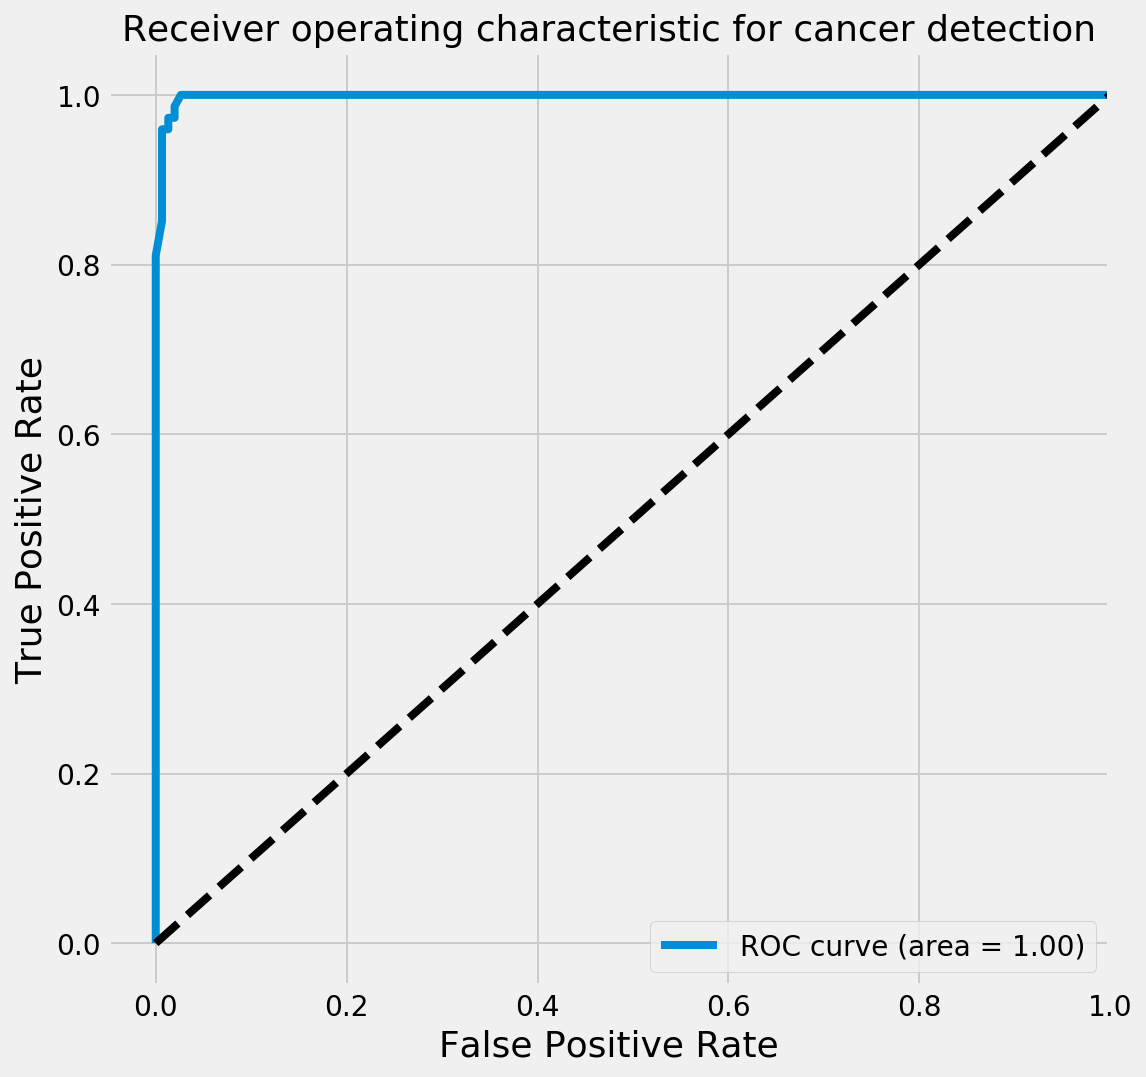

In [0]:
# For class 1, find the area under the curve.
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, Y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1 (has_cancer).
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for cancer detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

---

## Reference Table of Common Classification Metric Terms and Definitions

<br><br>

|  TERM | DESCRIPTION  |
|---|---|
|**TRUE POSITIVES** | The number of "true" classes correctly predicted to be true by the model. <br><br> `TP = Sum of observations predicted to be 1 that are actually 1.`<br><br> The true class in a binary classifier is labeled with 1.|
|**TRUE NEGATIVES** | The number of "false" classes correctly predicted to be false by the model. <br><br> `TP = Sum of observations predicted to be 0 that are actually 0.`<br><br> The false class in a binary classifier is labeled with 0.|
|**FALSE POSITIVES** | The number of "false" classes incorrectly predicted to be true by the model. This is the measure of **type I error**.<br><br> `TP = Sum of observations predicted to be 1 that are actually 0.`<br><br> Remember that "true" and "false" refer to the veracity of your guess, and "positive" and "negative" component refer to the guessed label.|
|**FALSE NEGATIVES** | The number of "true" classes incorrectly predicted to be false by the model. This is the measure of **type II error.**<br><br> `TP = Sum of observations predicted to be 0 that are actually 1.`<br><br>|
|**TOTAL POPULATION** | In the context of the confusion matrix, the sum of the cells. <br><br> `total population = tp + tn + fp + fn`<br><br>|
|**SUPPORT** | The marginal sum of rows in the confusion matrix or, in other words, the total number of observations belonging to a class, regardless of prediction. <br><br>|
|**ACCURACY** | The number of correct predictions by the model out of the total number of observations. <br><br> `accuracy = (tp + tn) / total_population`<br><br>|
|**PRECISION** | The ability of the classifier to avoid labeling a class as a member of another class. <br><br> `Precision = True Positives / (True Positives + False Positives)`<br><br>_A precision score of 1 indicates that the classifier never mistakenly classified the current class as another class. A precision score of 0 would mean that the classifier misclassified every instance of the current class. |
|**RECALL/SENSITIVITY**    | The ability of the classifier to correctly identify the current class. <br><br>`Recall = True Positives / (True Positives + False Negatives)`<br><br> A recall of 1 indicates that the classifier correctly predicted all observations of the class. A recall of 0 means the classifier predicted all observations of the current class incorrectly.|
|**SPECIFICITY** | Percent of times the classifier predicted 0 out of all the times the class was actually 0.<br><br> `specificity = tn / (tn + fp)`<br><br>|
|**FALSE POSITIVE RATE** | Percent of times the model predicts 1 when the class is 0.<br><br> `fpr = fp / (tn + fp)`<br><br>|
|**F1-SCORE** | The harmonic mean of the precision and recall. The harmonic mean is used here rather than the more conventional arithmetic mean because the harmonic mean is more appropriate for averaging rates. <br><br>`F1-Score = 2 * (Precision * Recall) / (Precision + Recall)` <br><br>_ Like the precision and recall scores, the F1 score's best value is 1 and worst value is 0. It is a useful metric for taking into account both measures at once._ |

<a id='resources'></a>

## Additional Resources

---

- A Simple Guide to [Confusion Matrix Terminology](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)
- A Deeper [Introduction to ROC](http://people.inf.elte.hu/kiss/13dwhdm/roc.pdf)
- A [University Resource](http://ebp.uga.edu/courses/Chapter%204%20-%20Diagnosis%20I/8%20-%20ROC%20curves.html) on Receiver Operation Characteristic Curves
- An Interactive Tool for [Playing With ROC Curves](http://www.navan.name/roc/)
- Data School's Video and Transcript on [ROC/AUC](http://www.dataschool.io/roc-curves-and-auc-explained/)
-  Rahul Patwari's [Video](https://www.youtube.com/watch?v=21Igj5Pr6u4) on ROC Curves